In [1]:
# 📦 기본 패키지 불러오기
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ⚙️ 디바이스 설정 (CPU 고정)
device = torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# 📁 HDF5 데이터셋 로더
class HDF5Dataset(Dataset):
    def __init__(self, input_path, output_path):
        self.input_file = h5py.File(input_path, 'r')
        self.output_file = h5py.File(output_path, 'r')
        self.X = self.input_file['subcubes']
        self.Y = self.output_file['subcubes']
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float().unsqueeze(0)  # (1, 122, 122, 122)
        y = torch.from_numpy(self.Y[idx]).float().unsqueeze(0)
        return x, y


In [3]:
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv3d(1, 8, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv3d(8, 16, 3, padding=1), nn.ReLU())
        self.pool = nn.MaxPool3d(2)

        self.middle = nn.Sequential(nn.Conv3d(16, 16, 3, padding=1), nn.ReLU())

        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False)
        self.dec2 = nn.Sequential(nn.Conv3d(32, 8, 3, padding=1), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Conv3d(16, 1, 3, padding=1))

    def forward(self, x):
        x1 = self.enc1(x)                          # (B, 8, 122, 122, 122)
        x2 = self.enc2(self.pool(x1))              # (B, 16, 61, 61, 61)
        x_mid = self.middle(x2)                    # (B, 16, 61, 61, 61)
        x_up = self.up(x_mid)                      # (B, 16, ~122, ~122, ~122)

        # ✂️ crop to match x2 (61x61x61)
        x_up_cropped = x_up[:, :, :61, :61, :61]

        x_concat2 = torch.cat([x2, x_up_cropped], dim=1)   # (B, 32, 61, 61, 61)
        x3 = self.dec2(x_concat2)
        x_up2 = self.up(x3)                       # (B, 8, ~122, ~122, ~122)

        # ✂️ crop to match x1
        x_up2_cropped = x_up2[:, :, :122, :122, :122]
        x_concat1 = torch.cat([x1, x_up2_cropped], dim=1)   # (B, 16, 122, 122, 122)

        out = self.dec1(x_concat1)                # (B, 1, 122, 122, 122)
        return out


In [4]:
# 🧪 데이터 준비
input_file = "/caefs/data/IllustrisTNG/subcube/input/subcubes_stride2_50mpc_parallel.h5"
output_file = "/caefs/data/IllustrisTNG/subcube/output/subcubes_stride2_50mpc_parallel.h5"

dataset = HDF5Dataset(input_file, output_file)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# 🔧 모델 초기화
model = UNet3D().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [5]:
# 🏋️‍♂️ 테스트용 학습 루프 (1 epoch만)
model.train()
loss_list = []

for batch_idx, (x, y) in enumerate(tqdm(loader)):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())  # 🔹 손실값 저장

    if batch_idx % 10 == 0:
        print(f"Step {batch_idx}, Loss: {loss.item():.4f}")
    
    if batch_idx == 100:  # 빠른 테스트용으로 30개만 학습
        break

  0%|          | 1/10000 [00:01<3:04:14,  1.11s/it]

Step 0, Loss: 4.6997


  0%|          | 11/10000 [00:08<1:57:58,  1.41it/s]

Step 10, Loss: 0.9425


  0%|          | 21/10000 [00:16<2:01:23,  1.37it/s]

Step 20, Loss: 0.7379


  0%|          | 31/10000 [00:22<1:51:26,  1.49it/s]

Step 30, Loss: 0.5338


  0%|          | 41/10000 [00:29<1:58:05,  1.41it/s]

Step 40, Loss: 0.4143


  1%|          | 51/10000 [00:36<1:50:00,  1.51it/s]

Step 50, Loss: 0.3131


  1%|          | 61/10000 [00:42<1:51:29,  1.49it/s]

Step 60, Loss: 0.2703


  1%|          | 71/10000 [00:48<1:39:50,  1.66it/s]

Step 70, Loss: 0.1521


  1%|          | 81/10000 [00:56<2:04:07,  1.33it/s]

Step 80, Loss: 0.1048


  1%|          | 91/10000 [01:03<2:11:30,  1.26it/s]

Step 90, Loss: 0.0974


  1%|          | 100/10000 [01:10<1:57:01,  1.41it/s]

Step 100, Loss: 0.0725


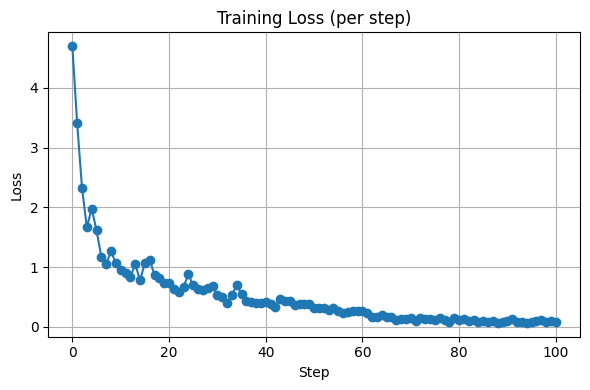

In [6]:
# 📉 학습 곡선 시각화
plt.figure(figsize=(6, 4))
plt.plot(loss_list, marker='o')
plt.title("Training Loss (per step)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

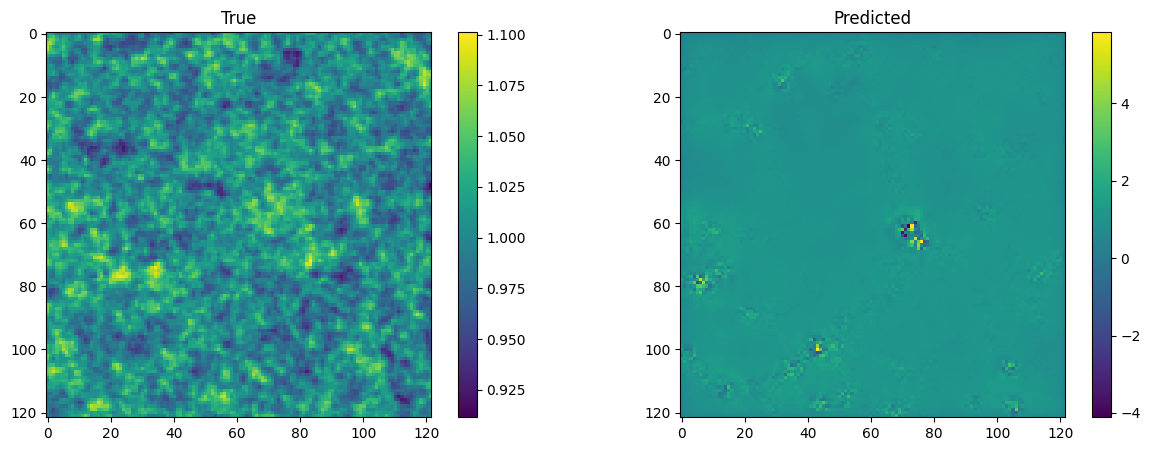

In [7]:
# 🖼️ 예측 결과 시각화 (중앙 슬라이스만)
model.eval()
with torch.no_grad():
    x, y = dataset[0]
    x = x.unsqueeze(0).to(device)
    pred = model(x).cpu().squeeze().numpy()
    truth = y.squeeze().numpy()

    slice_idx = 61
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(truth[slice_idx], cmap='viridis')
    plt.title("True")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(pred[slice_idx], cmap='viridis')
    plt.title("Predicted")
    plt.colorbar()
    plt.show()
